In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
# In the calibration, accessibility applies only to PT
car.car_los['accessibility'] = 0
sm.pt_los.loc[sm.pt_los['route_type']=='walk', 'accessibility'] = 0

In [5]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
print(len(sm.los))
sm.los.sample(3)

919779


,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","('Fz1', 'probability')","('Fz2', 'probability')","('Fz3', 'probability')","('Fz4', 'probability')","('Fz6', 'probability')"
467172,2213,0.000000,DE239,798,6480,729750,"[r_s_49962, r_s_49966, r_s_64929, r_s_118810, ...",8,DEA15,None,...,-5.083808,-2.499243,-5.921038,-3.618197,-4.149699,0.358572,0.439127,0.252255,0.110147,0.135670
664244,708,0.560669,DE124,149,14340,665362,"[r_l_9612, r_l_9613, r_l_392, r_l_393, r_l_929...",3,DEE01,None,...,-9.070296,-5.707221,-9.672903,-4.949156,-6.015793,0.012671,0.027983,0.009395,0.031328,0.024583
396249,2882,0.433683,DE27C,0,960,522222,"[bus_1050752, bus_1485338, bus_838320, bus_256...",9,DE91C,None,...,-3.161687,-0.054191,-3.484954,-3.577882,-3.480184,0.449458,0.494431,0.428567,0.085735,0.166421


In [6]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]

In [7]:
len(sm.los)

919779

In [8]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [9]:
# Scale time to hours
if sm.los['time'].mean() > 3600:
    sm.los['time'] = sm.los['time'] / 3600
sm.los['time'].mean()

3.430341990666602

### Prepare the logit model

In [10]:
# Link route types are going to be the PT nest's modes
route_types = ['rail_long', 'rail_short',
               'coach', 'bus', 'air','car', 'walk']

In [11]:
# Trip purposes from transport demand input data
segments = ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']

In [41]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
for s in segments:
    sm.los[(s, 'gc')] = sm.los['time'] + [c / vot[s, 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
        if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]

In [13]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results_splineGC_distVoT_knots2040_2.xlsx')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))
#df = excel.parse(1) # NL for all purposes
#params_root = df.set_index(df.columns[0])

In [14]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['pt']*4 + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['pt', 'root'],
                     data={p: col for p in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,
rail_long,pt,pt,pt,pt,pt
rail_short,pt,pt,pt,pt,pt
coach,pt,pt,pt,pt,pt
bus,pt,pt,pt,pt,pt
air,root,root,root,root,root
car,root,root,root,root,root
walk,root,root,root,root,root
pt,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN


In [15]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for seg in segments]
# For the nested structure
sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
                             for i in range(len(segments))]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6
rail_long,1.000000,1.000000,1.000000,1.000000,1.000000
rail_short,1.000000,1.000000,1.000000,1.000000,1.000000
coach,1.000000,1.000000,1.000000,1.000000,1.000000
bus,1.000000,1.000000,1.000000,1.000000,1.000000
air,1.000000,1.000000,1.000000,1.000000,1.000000
car,1.000000,1.000000,1.000000,1.000000,1.000000
walk,1.000000,1.000000,1.000000,1.000000,1.000000
root,1.000000,1.000000,1.000000,1.000000,1.000000
pt,0.781485,0.495034,0.727639,0.667023,0.790882


In [16]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail_short', 'asc_rail'),
               ('rail_long', 'asc_rail'),
               ('coach', 'asc_coach'), ('bus', 'asc_bus'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6
rail_short,-1.721759,0.206242,-2.756861,-2.495717,-2.575907
rail_long,-1.721759,0.206242,-2.756861,-2.495717,-2.575907
coach,-4.312099,-0.834806,-4.985405,-3.856950,-3.750469
bus,-2.887095,0.166777,-3.226523,-3.486204,-3.351647
air,-5.806420,-4.742467,-5.835578,-1.885106,-3.109832
car,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-3.853315,-1.502895,-2.617710,-3.064837,-2.135245
root,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
# Performance attributes for mode choice
#perf_attrs = ['gc_d']#, 'accessibility']
perf_attrs = [(s, 'gc_d') for s in segments]

In [26]:
# Beta parameters from calibration data
# IMPORTANT: watch the conversion
sm.utility_values = pd.DataFrame({seg: [0]*len(perf_attrs)
                                  for seg in segments}, index=perf_attrs)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(perf_attrs, segments):
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6
"(Fz1, gc_d)",-0.569374,0.000000,0.000000,0.000000,0.000000
"(Fz2, gc_d)",0.000000,-0.458182,0.000000,0.000000,0.000000
"(Fz3, gc_d)",0.000000,0.000000,-0.535864,0.000000,0.000000
"(Fz4, gc_d)",0.000000,0.000000,0.000000,-0.190095,0.000000
"(Fz6, gc_d)",0.000000,0.000000,0.000000,0.000000,-0.266527
mode_utility,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
for a, s in zip(perf_attrs, segments):
    sm.los[a] = sm.los[(s, 'gc')].apply(spline)
#sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [43]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,"(Fz1, gc_d)","(Fz2, gc_d)","(Fz3, gc_d)","(Fz4, gc_d)","(Fz6, gc_d)",length
origin,destination,route_type,,,,,,
DE266,DED2E,bus,0.444665,0.612813,0.523346,0.408654,0.494347,460286
DED2C,DE253,rail_short,5.389875,8.839204,7.141593,4.568966,6.376809,501843
DE21F,DE40B,air,0.000000,0.000000,0.000000,0.000000,0.000000,540274
DEB33,DEG01,bus,0.192211,0.332950,0.264625,0.163400,0.225243,599165
DE238,DEA12,rail_short,7.756364,11.967743,10.290908,6.792920,8.652196,825113


<AxesSubplot:xlabel='length'>

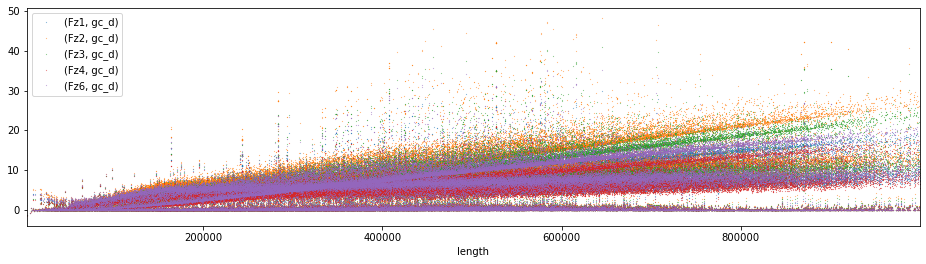

In [44]:
sm.los.set_index('length')[perf_attrs].sample(int(len(sm.los)/10)).plot(
    subplots=False, figsize=(16,4), linestyle=' ', marker='x', markersize=.6, alpha=.5)

## Mode Choice

In [45]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]


In [46]:
# Run the logit model to calculate probabilities
sm.step_logit(workers=2, decimals=8, nchunks=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]


In [47]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(801840, 12)
(801840, 12)


In [48]:
sm.probabilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short,rail_long
276336,DE21M,DEG0A,Fz2,1,0.0,0.001553,0.0,0.998447,0.000000,0.000000,0.995501,0.002946
156298,DEA24,DEC02,Fz1,1,0.0,0.597579,0.0,0.402421,0.300832,0.000282,0.101307,0.000000
650798,DEA59,DE272,Fz6,1,0.0,0.731931,0.0,0.268069,0.000000,0.000000,0.268069,0.000000
672823,DEE06,DE40F,Fz6,1,0.0,0.840791,0.0,0.159209,0.109077,0.000000,0.050132,0.000000
132210,DE27D,DE946,Fz1,1,0.0,0.252453,0.0,0.747547,0.000000,0.000000,0.716897,0.030650


In [49]:
sm.utilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short,rail_long
429503,DE94H,DEG05,Fz3,-5.610278,-inf,-5.902985,-inf,-6.981647,-inf,-inf,-6.981647,-inf
6313,DE732,DEB35,Fz1,-0.366218,-inf,-0.610211,-inf,-1.896352,-2.202462,-6.166583,-4.187666,-2.929573
690213,DE116,DED53,Fz6,-2.069336,-inf,-2.761499,-inf,-2.763468,-2.843889,-inf,-4.611198,-inf
426017,DE27E,DE247,Fz3,-2.345021,-inf,-4.145643,-inf,-2.525579,-2.595356,-inf,-6.522961,-4.299622
635802,DE93A,DEC02,Fz4,-1.594317,-inf,-2.160956,-inf,-2.432327,-inf,-inf,-3.048727,-2.769607


In [50]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,...,"(Fz1, utility)","(Fz2, utility)","(Fz3, utility)","(Fz4, utility)","(Fz6, utility)","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
635651,2084,0.408666,DE245,0,780,481625,"[bus_435383, bus_2287674, bus_2383025, bus_106...",7,DEC04,None,...,-2.972071,0.04623,-3.334838,-3.510276,-3.399613,0.373206,0.496172,0.40495,0.053565,0.140545


### Save model

In [52]:
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  3.00it/s]


In [53]:
sm.los.drop(["('Fz1', 'utility')", "('Fz2', 'utility')",
             "('Fz3', 'utility')", "('Fz4', 'utility')",
             "('Fz6', 'utility')", "('Fz1', 'probability')",
             "('Fz2', 'probability')", "('Fz3', 'probability')",
             "('Fz4', 'probability')", "('Fz6', 'probability')"],
            axis=1, inplace=True, errors='ignore')

In [54]:
# Save LoS table
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:31<00:00,  1.25it/s]


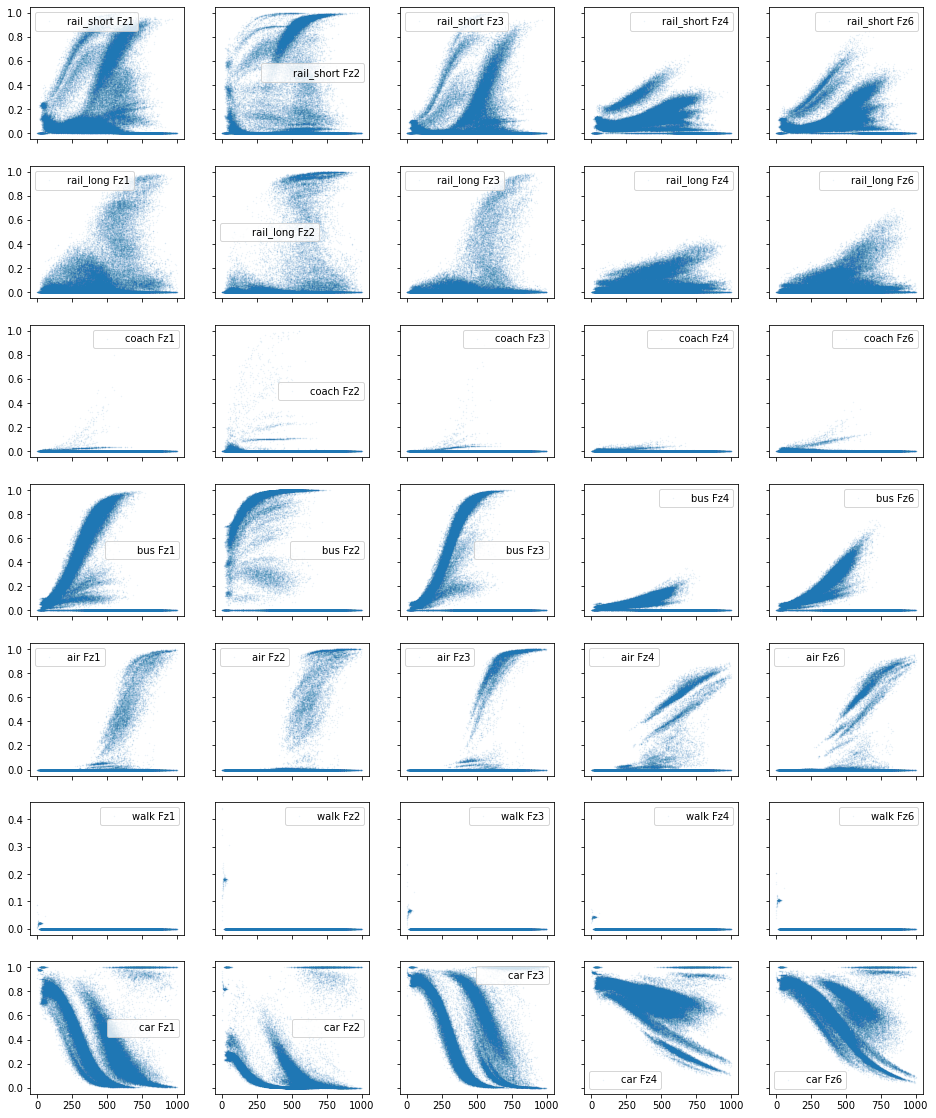

In [51]:
# Distance-distribution of probabilities
merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                on=['origin', 'destination'], how='inner')
modes = ['rail_short', 'rail_long', 'coach', 'bus', 'air', 'walk', 'car']
fig, ax = plt.subplots(nrows=7, ncols=5, sharex='all', sharey='row', figsize=(16,20))
for i, mode in zip(range(len(modes)), modes):
    for j, seg in zip(range(5), merged['segment'].unique()):
        x = merged.loc[merged['segment']==seg, 'length'] / 1000
        y = merged.loc[merged['segment']==seg, mode]
        ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
        #p = np.poly1d(np.polyfit(x, y, deg=3))
        #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
        ax[i,j].legend()